In [72]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import postprocess as pp
# import plots
import os
import visuals

In [73]:
pp.__file__

'/Users/kumiori3/Documents/WIP/Nature/mec647/playground/nb/postprocess.py'

In [74]:
def plot_operator_spectrum(data):
    figure, axis = plt.subplots(1, 1)
    scale = data['eigs-ball'].values[0][0]
    colour = np.where(data['eigs-cone'] > 0, 'C1', 'C2')
    colour = np.where(data['eigs-cone'] > 0, 'C1', 'C2')
    # Concatenate data for all load steps
    load_steps_all = np.concatenate([np.full_like(eigenvalues, load_step) for load_step, eigenvalues in zip(data['load'], data['eigs-ball'])])
    eigenvalues_all = np.concatenate(data['eigs-ball'])

    # Create a scatter plot with vertical alignment
    axis.scatter(load_steps_all, eigenvalues_all / scale, marker='o', c='C0', label='Eigenvalues in vector space')
    axis.scatter(data.load, data['eigs-cone'], marker = 'd', c=colour, s=60, label='Eigenvalues in cone')

    axis.set_xlabel('Load Step')
    axis.set_ylabel('Eigenvalues')
    axis.set_title('Spectrum of Nonlinear Operator $H_{\\ell}:=E_\\ell\'\'(y_t)$')
    axis.set_yticks([0, 1, -3])
    axis.axhline(0., c='k')
    axis.set_ylim(-.5, 1.5)
    axis.grid(True)
    axis.legend()
    
    return figure, axis
    # axis.show()

def find_closest_index(physical_time, time_data):
    # Extract the time values from the array
    discrete_times = time_data[:, 0]

    # Find the index of the closest discrete time
    closest_index = np.argmin(np.abs(discrete_times - physical_time))

    # Return the corresponding index value
    return time_data[closest_index, 1]


# Investigating the fundamental traction


We study fundamental problem of a one-dimensional variational evolution,
which features non-trivial stability properties
such as:
    -
    -
    -

The problem is as follows:

Find $y_t$ such that:

GS)
$$
E(y_t)\leq E(z), \quad \forall z \in A(y_t)
$$

LS) 
$\exists \bar h: $
$$
E(y_t)\leq E(y_t + z), \quad \forall z \in .., ||z||\leq h
$$


In [58]:
experiment = '../../test/output/one-dimensional-bar/MPI-1/50/55045ae161aef937cdd5e62625e01cd3'
params, data, signature = pp.load_data(experiment)


FileNotFoundError: [Errno 2] No such file or directory: '../../test/output/one-dimensional-bar/MPI-1/50/55045ae161aef937cdd5e62625e01cd3/parameters.yaml'

In [ ]:
plot_operator_spectrum(data)

NameError: name 'data' is not defined

## Check the Profiles

In [ ]:
data['load'][13]

NameError: name 'data' is not defined

In [ ]:
modes_data = np.load(os.path.join(experiment, 'mode_shapes_data.npz'), allow_pickle=True)


In [ ]:
modes_data["time_steps"]

array([1.02631579, 1.10526316, 1.18421053, 1.26315789, 1.34210526,
       1.42105263, 1.5       ])

In [ ]:
mode = read_mode_data_from_npz(modes_data, time_step=data['load'][13], num_modes=1, num_points=10)
_fig, _axes = plot_fields_for_time_step(mode)

NameError: name 'read_mode_data_from_npz' is not defined

## Analytical treatment

In [ ]:
class DefaultDamage:
    def __init__(self, state, matpar, name = "Default damage model", slug = "atk"):
        self.state = state
        self.matpar = matpar
        self.str = name
        self.slug = slug

    def _a(self, α):
        _α = self.state[α]
        # _α = α
        # _E0 = self.matpar[E0]
        _k = self.matpar["k"]

        return (1 - α) / ((_k-1) * α + 1)

    def _w(self, _α):
        # _α = α
        # _w1 = self.matpar["w1"]

        return self.matpar["w1"] * _α

    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _elastic(self, state):
        _E0 = self.matpar["E0"]
        _u = state[u]
        _α = state[α]

        return 1./2. * _E0 * self._a(_α) * sp.diff(_u, x)**2 

    def _damage(self, state):
        _α = state[α]
        matpar = self.matpar
        _w1 = matpar["w1"]
        _η = matpar["η"]

        return _w1 * (self._w(_α) + matpar["η"]**2 * (sp.diff(_α, x))**2 )

    def __str__(self):
     return self.str

class DamageATn(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, slug, name = "ATn Damage Model"):
        super(DamageATn, self).__init__(state, matpar, name = name, slug = slug)

    def _a(self, α):
        return (1 - α)**2

    def _w(self, _α):
        _α = α
        _n = self.matpar["n"]
        return _α**_n

class ModelAnalysis:
    """Helper class to analyse stability properties of a model"""

    def __init__(self, model):
        self.model = model
        self.state = model.state
        _state = self.state
        self.matpar = model.matpar

        self._s = 1/self.model._a(_state[α])
        self._sp = sp.diff(self._s, _state[α], 1)
        self._spp = sp.diff(self._s, _state[α], 2)

        self._a = self.model._a(_state[α])
        self._ap = sp.diff(self._a, _state[α], 1)
        self._app = sp.diff(self._a, _state[α], 2)

        self._w = self.model._w(_state[α])
        self._wp = sp.diff(self._w, _state[α])
        self._wpp = sp.diff(self._w, _state[α], 2)
        
        _symbols = ["x", "t", "L"]

        # Create a dictionary of symbols
        self.symbols = {name: sp.Symbol(name) for name in _symbols}

        # self.criterion()

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state

        _u0 = t*x/L
        _alpha0 = 0

        _crit = sp.diff(model.energy(state), α) \
            .subs({u: _u0, α: _alpha0})         \
            .simplify()

        self.crit = _crit

        return _crit
    
    def _homogeneous_alpha(self, matpar = None):
        t, x, L = self.symbols["t"], self.symbols["x"], self.matpar["L"]
        _u0 = t*x/L
        state = self.state
        
        if matpar is not None:
            _matpar = matpar
        else:
            _matpar = self.matpar

        try:
            _eq = sp.diff(self.model.energy(state), α) \
                .subs({u: _u0, α: α})         \
                .simplify()

            _ah = sp.solve(_eq, α)

        # except NotImplementedError as e:
        except:
            _eq = sp.diff(self.model.energy(state), α)   \
                .subs({u: _u0, α: α})                   \
                .subs(_matpar)                   \
                .simplify()

            _ah = sp.solve(_eq, α)

        return _ah
    
    def plot_homogeneous_alpha(self, matpar={}):
        ah = self._homogeneous_alpha()
        t = self.symbols["t"]
        _tc = self.critical_load_N(matpar)

        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        subcritical_times = np.linspace(0., _tc)
        axis.plot(subcritical_times, [0 for t in subcritical_times], c="C0", lw=2)

        supercritical_times = np.linspace(_tc, 3)

        for _a in ah:
            _af = sp.lambdify(t, _a.subs(matpar), "numpy")

            axis.plot(supercritical_times, [_af(t)
                      for t in supercritical_times], c="C0")

        axis.set_xlim(0, 3)
        axis.set_ylim(-.1, 1)

        axis.axvline(_tc, c='k')
        axis.axhline(1, c='k', ls='--')
        
        axis.set_yticks([0, 1])
        axis.set_xticks([0, _tc], [0, "$t_c$"])
        
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        # axis.spines['bottom'].set_visible(False)
        axis.spines['left'].set_visible(False)
        axis.set_xlabel('$t$')
        axis.set_ylabel('$\\alpha$')

        axis.spines['bottom'].set_color('k')
        # axis.spines['top'].set_color('k')
        axis.xaxis.label.set_color('k')
        axis.tick_params(axis='x', colors='k')

        return fig, axis

    def plot_homogeneous_stress(self, matpar={}, ah=None, elements = 30):

        if ah is None:
            ah = self._homogeneous_alpha()

        # _tc = self.critical_load_N(_matpar)
        try:
            _tc = self.critical_load_N(matpar)
        except:
            _tc = self._critical_load

        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        times = np.linspace(0, 3, elements)

        _sf = sp.lambdify(t, self._stress(ah=ah, matpar = matpar).subs(_matpar), "numpy")

        # axis.plot(np.linspace(0, 3), [_sf(t) for t in times], c="C0")
        axis.plot(times, [_sf(t) for t in times], c="C0")

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        axis.set_xlim(0, 3)
        axis.set_ylim(-.1, 1)

        axis.axvline(_tc, c='k')
        axis.axhline(1, c='k', ls='--')
        
        axis.set_yticks([0, 1])
        axis.set_xticks([0, _tc], [0, "$t_c$"])
        
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        # axis.spines['bottom'].set_visible(False)
        axis.spines['left'].set_visible(False)
        axis.set_xlabel('$t$')
        axis.set_ylabel('$\\sigma$')

        axis.spines['bottom'].set_color('k')
        # axis.spines['top'].set_color('k')
        axis.xaxis.label.set_color('k')
        axis.tick_params(axis='x', colors='k')

        return fig, axis


    def _stress(self, ah=None, matpar={}):
        t, x, L = self.symbols["t"], self.symbols["x"], self.matpar["L"]
        _u0 = t*x/L

        if ah is None:
            return
        _ah = ah

        _tc = self.critical_load_N(matpar)
        
        stress_alpha = sp.Piecewise(
            (sp.sqrt(2 * self._wp / self._sp).subs({α: _ah}), t >= _tc),
            (sp.diff(_u0, x).subs(matpar), t < _tc))

        # return sp.sqrt( 2* self._wp / self._sp).subs({α: _ah})
        return stress_alpha

    def critical_load(self, matpar = {}):
        t = self.symbols["t"]
        
        ans = sp.solve(self.crit, t)
        _ = [t.subs(matpar) for t in ans]
        # print(ans)
        # print(np.array(_))
        positive = np.where(np.array(_) >= 0)[0][0]
        # pdx
        self._critical_load = ans[positive]
        return ans[positive]

    def critical_load_N(self, _matpar={}):
        return np.float64(self._critical_load.subs(_matpar))



In [ ]:

E0, L, w1, η, σc = sp.symbols('E0 L w1 η σ_c')
x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)

n = sp.symbols('n')

state = {u: u, α: α}



In [ ]:
matpar = {"n": 1, "E0": E0, "w1": w1, "η": η, "L": L}
_matpar = {"n": 1, "E0": 1, "w1": 1, "η": .1, "L": 1}

at1 = DamageATn(state, matpar=matpar,
                name="At1 Damage Model",
                slug=f"at1")

ana = ModelAnalysis(at1)

ana.criterion()
at1.energy(state)

0.5*E0*(1 - α(x))**2*Derivative(u(x), x)**2 + w1*(η**2*Derivative(α(x), x)**2 + α(x))

In [ ]:
ana.critical_load(matpar=_matpar)

L*sqrt(w1/E0)

In [ ]:
ana.criterion()
ana._homogeneous_alpha()


[1 - L**2*w1/(E0*t**2)]

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='$t$', ylabel='$\\alpha$'>)

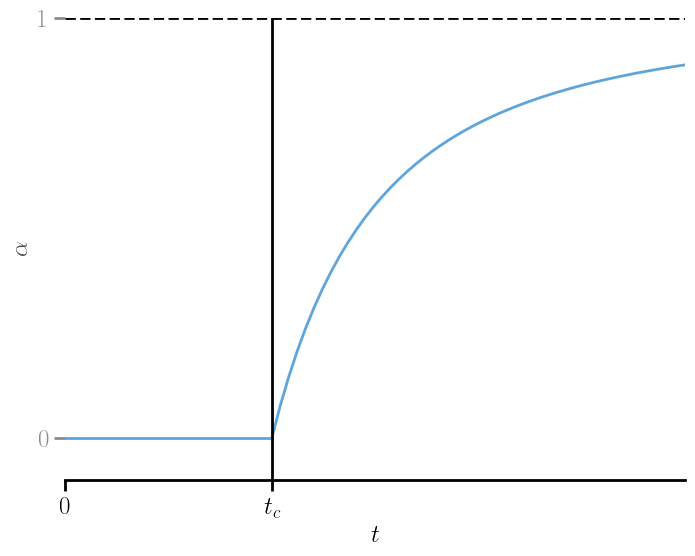

In [ ]:
ana.plot_homogeneous_alpha(matpar = _matpar)

In [ ]:
ana._stress(ana._homogeneous_alpha()[0], matpar=_matpar)

Piecewise((sqrt(L**6*w1**3/(E0**3*t**6)), t >= 1.0), (t, True))

<lambdifygenerated-2>:2: RuntimeWarning: divide by zero encountered in scalar power
  return select([greater_equal(t, 1.0),True], [sqrt(t**(-6.0)),t], default=nan)


(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='$t$', ylabel='$\\sigma$'>)

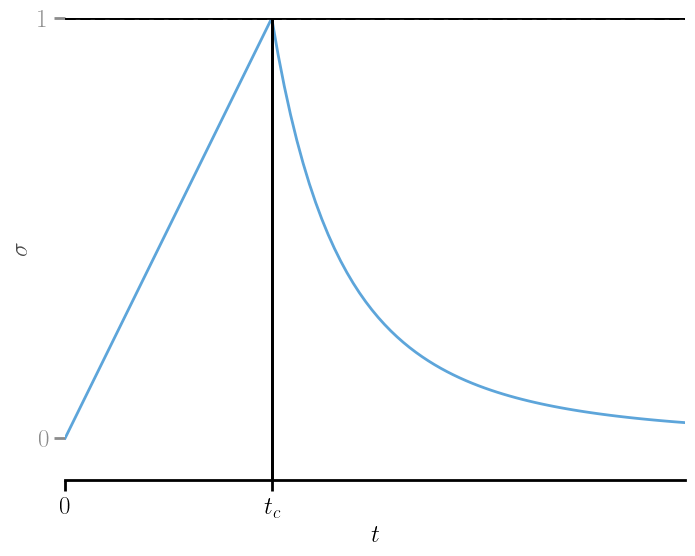

In [ ]:
ana.plot_homogeneous_stress(matpar = _matpar, ah=ana._homogeneous_alpha()[0], elements=100)

In [ ]:
_uh = t*x/L
_ah = ana._homogeneous_alpha()[0]

_stress = ana._stress(_ah, matpar=_matpar)

In [ ]:
_B0 = (1/2*ana._spp * _stress**2 - ana._wpp).subs(_matpar).subs({α: _ah})
_A = (2 * _matpar["η"]**2 / _B0).subs(_matpar)
_B = (ana._a.subs({α: _ah}).simplify() / _B0).subs(_matpar)
_C = - (ana._ap/ana._a * ana.symbols["t"]).subs(_matpar).subs({α: _ah}).simplify().subs(_matpar)

In [ ]:
_matpar

{'n': 1, 'E0': 1, 'w1': 1, 'η': 0.1, 'L': 1}

In [ ]:
_Rloc = (sp.pi**2*_A)**(1/3)*(_B*_C**2)**(2/3)
_Rloc.subs({η: .1})
# _f = sp.lambdify(t, _Rloc, "numpy")
# [_f(t) for t in supercritical_times]


0.227996792890226*pi**0.666666666666667*(Piecewise((t**6, t >= 1.0), (t**(-2), True))/t**8)**0.333333333333333*(Piecewise((t**6, t >= 1.0), (t**(-2), True))/t**6)**0.666666666666667

In [ ]:
_Rhomog = _B*_C**2
_f = sp.lambdify(t, _Rhomog, "numpy")
# _f(_tc)


_B*_C**2

NameError: name '_B' is not defined

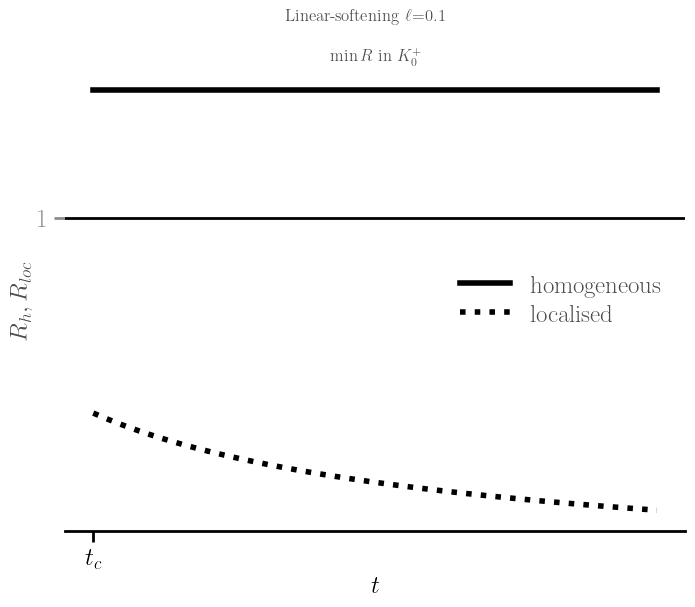

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(8, 6))
_tc = np.float32(ana.critical_load(_matpar).subs(_matpar).evalf())

supercritical_times  = np.linspace(_tc, 3)
_Rhomog = _B*_C**2
_f = sp.lambdify(t, _Rhomog, "numpy")
axis.plot(supercritical_times, [_f(t)
            for t in supercritical_times], c="k", label="homogeneous", lw=4)

_Rloc = ((sp.pi**2*_A)**(1/3)*(_B*_C**2)**(2/3)).subs(_matpar)
_f = sp.lambdify(t, _Rloc, "numpy")
axis.plot(supercritical_times, [_f(t)
            for t in supercritical_times], c="k", ls=':' , label="localised", lw=4)

axis.legend( prop={'size': 18})
axis.axhline(1, c='k')
# plt.plot()
axis.set_title('$\min R$ in $K^+_0$')
# fig.suptitle(f"{ana.model} $\ell$={_matpar[𝓁]}")
fig.suptitle(f"Linear-softening $\ell$={_matpar['η']}")
axis.set_xlabel('$t$')
axis.set_ylabel('$R_{h}, R_{loc}$')
axis.set_yticks([1])
axis.set_xticks([_tc], ['$t_c$'])
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
# axis.spines['bottom'].set_visible(False)
axis.spines['left'].set_visible(False)

axis.spines['bottom'].set_color('k')
axis.spines['top'].set_color('k')
axis.xaxis.label.set_color('k')
axis.tick_params(axis='x', colors='k')

### AT2

In [ ]:

E0, L, w1, η, σc, n = sp.symbols('E0 L w1 η σ_c n')

x, t = sp.symbols('x t')

α = sp.Function('α')(x)
u = sp.Function('u')(x)

state = {u: u, α: α}


matpar = {"n": 2, "E0": E0, "w1": w1, "η": η, "L": L}
_matpar = {"n": 2, "E0": 1, "w1": 1, "η": .1, "L": 1}


at2 = DamageATn(state, matpar=matpar,
                name="At2 Damage Model",
                slug=f"at2")

ana = ModelAnalysis(at2)

ana.criterion()
at2.energy(state)

0.5*E0*(1 - α(x))**2*Derivative(u(x), x)**2 + w1*(η**2*Derivative(α(x), x)**2 + α(x)**2)

In [ ]:
ana.critical_load(matpar=_matpar)
ana._homogeneous_alpha()


[E0*t**2/(E0*t**2 + 2*L**2*w1)]

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='$t$', ylabel='$\\alpha$'>)

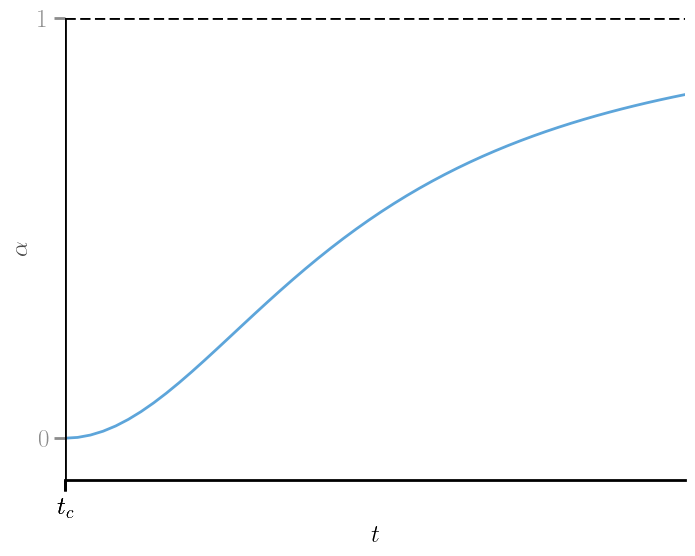

In [ ]:
ana.plot_homogeneous_alpha(matpar = _matpar)

In [ ]:
ana._stress(ana._homogeneous_alpha()[0], matpar=_matpar)

Piecewise((sqrt(2)*sqrt(E0*t**2*(-E0*t**2/(E0*t**2 + 2*L**2*w1) + 1)**3/(E0*t**2 + 2*L**2*w1)), t >= 0), (t, True))

In [ ]:
_uh = t*x/L
_ah = ana._homogeneous_alpha()[0]

_stress = ana._stress(_ah, matpar=_matpar)

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='$t$', ylabel='$\\sigma$'>)

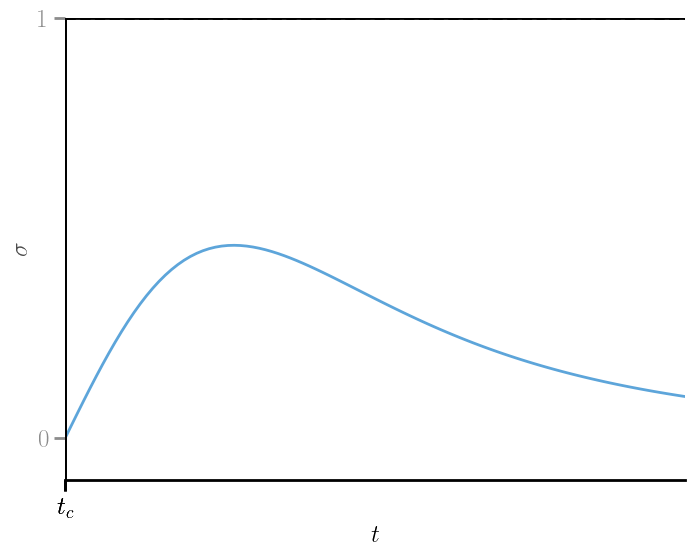

In [ ]:
ana.plot_homogeneous_stress(matpar = _matpar, ah=ana._homogeneous_alpha()[0], elements=100)

<!-- $$
a(\alpha) \int_0^{1} \left( v'+\frac{a'}{a}t\beta \right)^{2}
-\sigma ^{2}\int_0^1 \left( s''-\frac{w''}{\sigma^{2}}\right) \beta ^{2}+\ell^2 \beta^{2}.
$$ -->


$$
E''(y^*)(y, y)=
a(\alpha) \int_0^{1} \left( v'+\frac{a'}{a}t\beta \right)^{2}
-\int_0^1 \left(\frac{\sigma ^{2}s''}{2}-{w''}\right) \beta ^{2}+2\ell^2 \beta'^{2}
+ \frac{1}{\ell_e^2} v'^{2}.
$$


$$
\mathcal R(v, \beta):=  \frac{A\int \beta'^{2} + \int_0^{1} B\left( v' - C\beta \right)^{2}  + D\int_0^1 v'^2}{ \int_0^1\beta ^{2}}
$$


$$
A = \frac{2\ell^2}{\frac{\sigma^2 s''}{2} - w''}\qquad
B = \frac{a}{\frac{\sigma^2 s''}{2} - w''}\qquad
C = -\frac{a'}{a}t, \qquad
$$

In [ ]:
(_stress**2).subs(_matpar).simplify()

Piecewise((16*t**2/(t**2 + 2)**4, t >= 0), (t**2, True))

In [ ]:
_B0 = (1/2*ana._spp * _stress**2 - ana._wpp).subs(_matpar).subs({α: _ah})
_A = (2 * _matpar["η"]**2 / _B0).subs(_matpar)
_B = (ana._a.subs({α: _ah}).simplify() / _B0).subs(_matpar)
_C = - (ana._ap/ana._a * ana.symbols["t"]).subs(_matpar).subs({α: _ah}).simplify().subs(_matpar)

AttributeError: 'ModelAnalysis' object has no attribute 'slug'

<lambdifygenerated-12>:2: RuntimeWarning: invalid value encountered in scalar power
  return 0.683990378670679*pi**0.666666666666667*(t**2/(3.0*select([greater_equal(t, 0),True], [0,t**2], default=nan) - 2))**0.666666666666667*((3.0*select([greater_equal(t, 0),True], [0,t**2], default=nan) - 2)**(-1.0))**0.333333333333333


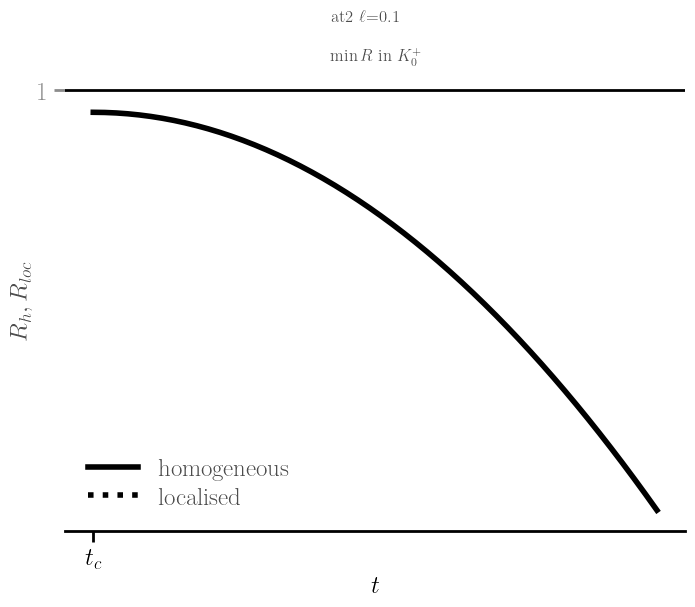

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(8, 6))
_tc = np.float32(ana.critical_load(_matpar).subs(_matpar).evalf())

supercritical_times  = np.linspace(_tc, 3)
_Rhomog = _B*_C**2
_f = sp.lambdify(t, _Rhomog, "numpy")
axis.plot(supercritical_times, [_f(t)
            for t in supercritical_times], c="k", label="homogeneous", lw=4)

_Rloc = ((sp.pi**2*_A)**(1/3)*(_B*_C**2)**(2/3)).subs(_matpar)
_f = sp.lambdify(t, _Rloc, "numpy")
axis.plot(supercritical_times, [_f(t)
            for t in supercritical_times], c="k", ls=':' , label="localised", lw=4)

axis.legend( prop={'size': 18})
axis.axhline(1, c='k')
# plt.plot()
axis.set_title('$\min R$ in $K^+_0$')
# fig.suptitle(f"{ana.model} $\ell$={_matpar[𝓁]}")
fig.suptitle(f"{ana.model.slug} $\ell$={_matpar['η']}")
axis.set_xlabel('$t$')
axis.set_ylabel('$R_{h}, R_{loc}$')
axis.set_yticks([1])
axis.set_xticks([_tc], ['$t_c$'])
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
# axis.spines['bottom'].set_visible(False)
axis.spines['left'].set_visible(False)

axis.spines['bottom'].set_color('k')
axis.spines['top'].set_color('k')
axis.xaxis.label.set_color('k')
axis.tick_params(axis='x', colors='k')

## Verification

We solve:
$$ \min R(z) \text{ in }V, K^+_0$$

In [ ]:

def book_of_the_numbers():
    """This function, formerly called `fuck_dgsi`, invokes the book of the numbers
    to get three real quantities, according to the scriptures.
    
    @article{pham:2011-the-issues,
        author = {Pham, Kim and Marigo, Jean-Jacques and Maurini, Corrado},
        date-added = {2015-08-24 14:23:19 +0000},
        date-modified = {2022-08-10 11:03:49 +0200},
        journal = {Journal of the Mechanics and Physics of Solids},
        number = {6},
        pages = {1163--1190},
        publisher = {Elsevier},
        title = {The issues of the uniqueness and the stability of the homogeneous response in uniaxial tests with gradient damage models},
        volume = {59},
        year = {2011},
        }
        
    Fuck Elsevier.
    
"""
    while True:
        a = np.random.rand()
        b = np.random.rand()*3
        c = (np.random.choice([-1, 1], 1) * np.random.rand(1))[0]*3  # Generate three random numbers between 0 and 1

        # Check conditions
        if a > 0 and b > 0 and c != 0:
            break

    return {"a": a, "b": b, "c": c}


In [ ]:
parameters = book_of_the_numbers()
print(f"a: {parameters.get('a')}, b: {parameters.get('b')}, c: {parameters.get('c')}")


a: 0.8207436427299781, b: 0.03122725088129108, c: -2.6209236050532305


## In the Vector Space

In [ ]:
np.min([b*c**2,np.pi**2*a])



NameError: name 'b' is not defined

In [ ]:

x = sp.symbols('x', real=True)
v = sp.Function('v', real=True)(x)
β = sp.Function('β', real=True)(x)
C, A = sp.symbols('C, A', real=True)

def solve_minimum(parameters):
    a = parameters["a"]
    b = parameters["b"]
    c = parameters["c"]
    _condition = b * c**2 < np.pi**2 * a 
    print(f"bc**2 = {np.around(b*c**2, 2)}, π**2 * a = {np.around(np.pi**2 * a, 2)}")
    
    if _condition:
        print('case 1')
        _subs = {A: 0}
    elif not _condition:
        print('case 2')
        _subs = {C: 0}

    return np.min([b*c**2,np.pi**2*a]), _subs

def solve_eigenspace_vector(parameters, idx = 0):
    x = sp.symbols('x', real=True)
    v = sp.Function('v', real=True)(x)
    β = sp.Function('β', real=True)(x)
    C, A = sp.symbols('C A')
    
    a = parameters["a"]
    b = parameters["b"]
    c = parameters["c"]    
    
    if b * c**2 < sp.pi**2 * a:
        print('case 1')
        _subs = {A: 0}
        A = 0
    elif b * c**2 > sp.pi**2 * a:
        print('case 2')
        _subs = {C: 0}
        C = 0
    
    
    β = C + A*sp.cos(sp.pi * x)
    v = c * A / sp.pi * sp.sin(sp.pi * x)

    depends_on_A = np.any([sp.symbols('A') in expression.free_symbols for expression in [v, β]])
    depends_on_C = np.any([sp.symbols('C') in expression.free_symbols for expression in [v, β]])
    
    _norm = sp.sqrt(np.sum([sp.integrate(eigenfunction**2, (x, 0, 1)) for eigenfunction in (v, β)]))

    print([expression.free_symbols for expression in [v, β]])
    print(_norm, depends_on_A, depends_on_C)
    
    if depends_on_A:
        print('depends_on_A')
        _normalise = [{sp.symbols('A'): ay} for ay in sp.solve(_norm - 1, A)]
    elif depends_on_C:
        print('depends_on_C')
        _normalise = [{sp.symbols('C'): cy} for cy in sp.solve(_norm - 1, C)]
        
    return {"v": v.subs(_normalise[idx]), "β": β.subs(_normalise[idx]), "D": 0}

    # return (v, β), _normalise

def solve_eigenspace_cone(parameters, idx = 0):
    x = sp.symbols('x', real=True)
    v = sp.Function('v', real=True)(x)
    β = sp.Function('β', real=True)(x)
    C, A = sp.symbols('C A')
    
    a = parameters["a"]
    b = parameters["b"]
    c = parameters["c"]    
    D = 0
    
    if b * c**2 < sp.pi**2 * a:
        print('case 1')
        β = C
        
    elif b * c**2 > sp.pi**2 * a:
        print('case 2')
        # D = sp.symbols('D')
        D = (sp.pi**2 * a / (b * c**2))**(1/3)
        β = sp.Piecewise(
            (C *(1 + sp.cos(sp.pi * x / D)), (0 <= x) & (x <= D)),
            (0, True)
            )
        
        _min = (np.pi**2 * a)**(1/3) * (b * c**2)**(2/3)
        
    elif b * c**2 == sp.pi**2 * a:
        print('case eq')
        _min = b * c**2
        _subs = {C: 0}
        C = 0
        β = C + A*sp.cos(sp.pi * x)
        # abs(A) < C
    
    depends_on_A = sp.symbols('A') in β.free_symbols
    depends_on_C = sp.symbols('C') in β.free_symbols
    depends_on_D = sp.symbols('D') in β.free_symbols
    
    _norm = sp.sqrt(sp.integrate(β**2, (x, 0, 1)))

    # print([expression.free_symbols for expression in [v, β]])
    print(_norm)
    
    if depends_on_A:
        print('depends_on_A')
        _normalise = [{sp.symbols('A'): ay} for ay in sp.solve(_norm - 1, A)]
    elif depends_on_C:
        print('depends_on_C')
        _normalise = [{sp.symbols('C'): cy} for cy in sp.solve(_norm - 1, C) if cy > 0]
    elif depends_on_D:
        print('depends_on_D')
    
    return {"v": 0, "β": β.subs(_normalise[idx]), "D": D}

def plot_eigenspace(eigenspace, normalisation):
    (v, β) = eigenspace

    v_normalised = v.subs(normalisation[0])
    β_normalised = β.subs(normalisation[0])


    v_func = sp.lambdify(x, v_normalised, 'numpy')
    β_func = sp.lambdify(x, β_normalised, 'numpy')

    x_values = np.linspace(0, 1, 100)


    fig, axis = plt.subplots(1, 2, figsize=(8, 6))

    # plt.plot(x_values, x_values, label='v(x)')
    axis[0].plot(x_values, [v_func(x) for x in x_values], label='v(x)')
    axis[0].set_title('Eigenfunction v(x)')
    axis[0].set_xlabel('$x$')
    axis[0].set_ylabel('$v(x)$')

    axis[1].plot(x_values, [β_func(x) for x in x_values], label='β(x)')
    axis[1].set_title('Eigenfunction $\\beta$(x)')
    axis[1].set_xlabel('$x$')
    axis[1].set_ylabel('$\\beta$(x)')

    fig.tight_layout()

    return fig, axis


In [ ]:
# a, b, c = sp.symbols("a, b, c", real=True)

parameters = book_of_the_numbers()
print(parameters)
a = parameters["a"]
b = parameters["b"]
c = parameters["c"]
print(f"bc**2 = {np.around(b*c**2, 2)}, π**2 * a = {np.around(np.pi**2 * a, 2)}")

β = C + A * sp.cos(sp.pi * x)
v = c * A / sp.pi * sp.sin(sp.pi * x)

# Conditions for A and C
if b * c**2 < sp.pi**2 * a:
    print('case 1')
    _subs = {A: 0}
elif b * c**2 > sp.pi**2 * a:
    print('case 2')
    _subs = {C: 0}

print([x.subs(_subs) for x in (v, β)])

{'a': 0.1908472901448448, 'b': 2.985737302531073, 'c': 1.4780186038665675}
bc**2 = 6.52, π**2 * a = 1.88
case 2
[1.47801860386657*A*sin(pi*x)/pi, A*cos(pi*x)]


In [ ]:
parameters = book_of_the_numbers()

_min = solve_minimum(parameters)
eigenspace, normalisation = solve_eigenspace_vector(parameters)

print(f'Minimum of Fundamental Quotient {_min[0]}, Eigenspace {eigenspace}, Normalisation {normalisation}')

bc**2 = 0.57, π**2 * a = 7.56
case 1
case 1
[set(), {C}]
sqrt(C**2) False True
depends_on_C


ValueError: too many values to unpack (expected 2)

In [ ]:
# sp.sqrt(sp.integrate(eigenfunction**2, (x, 0, 1)))
_norm = sp.sqrt(np.sum([sp.integrate(eigenfunction**2, (x, 0, 1)) for eigenfunction in (v, β)]))
A_solution = sp.solve(_norm - 1, A)
print(f"Solutions for A: {A_solution}")


Solutions for A: [-1.22606318412651*sqrt(0.999999999999998 - C**2), 1.22606318412651*sqrt(0.999999999999998 - C**2)]


bc**2 = 10.8, π**2 * a = 6.81
case 2
case 2
[{x, A}, {x, A}]
1.36966917852371*sqrt(A**2/pi**2 + 0.266525421185975*A**2) True False
depends_on_A
[{A: -1.20379058141872}, {A: 1.20379058141872}]


(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Eigenfunction v(x)'}, xlabel='$x$', ylabel='$v(x)$'>,
        <Axes: title={'center': 'Eigenfunction $\\beta$(x)'}, xlabel='$x$', ylabel='$\\beta$(x)'>],
       dtype=object))

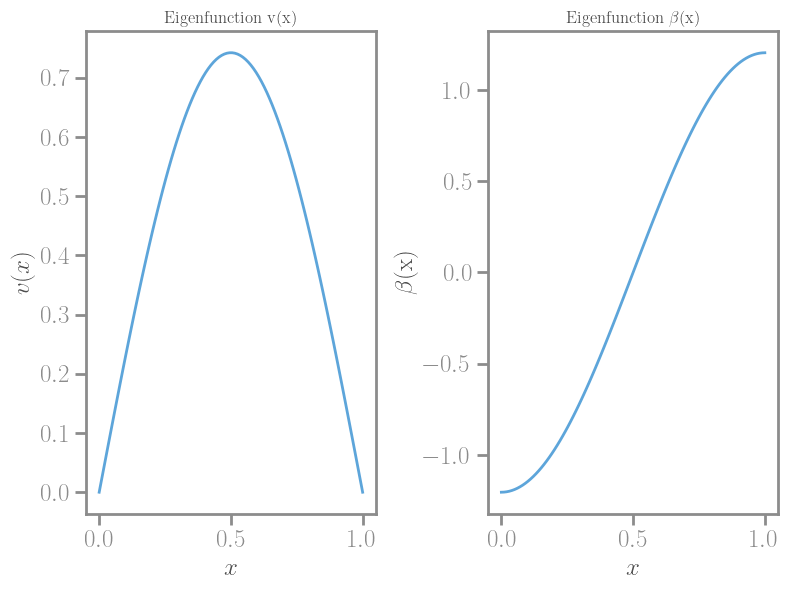

In [ ]:
parameters = book_of_the_numbers()
_min = solve_minimum(parameters)
eigenspace, normalisation = solve_eigenspace_vector(parameters)
print(normalisation)
plot_eigenspace(eigenspace, normalisation)

In [ ]:
parameters = book_of_the_numbers()

_eigenspace = solve_eigenspace_cone(parameters)
# β.subs(normalisation[0])
# β, normalisation
_eigenspace

case 2
sqrt(0.0847080151674313*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.0847080151674313*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.338832060669725*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.0847080151674313*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.169416030334863*pi**0.666666666666667)*sqrt(C**2)
depends_on_C


{'v': 0,
 'β': Piecewise((1.35444225939573*cos(5.9026291551244*pi**0.333333333333333*x) + 1.35444225939573, (x >= 0) & (x <= 0.169416030334863*pi**0.666666666666667)), (0, True)),
 'D': 0.169416030334863*pi**0.666666666666667}

In [ ]:
# sp.evalf(D)
type(sp.N(D))
# np.around(sp.N(D), 2)
np.around(float(sp.N(D)), 2)

TypeError: Cannot convert expression to float

In [ ]:
β

1

case 2
sqrt(0.222368337298163*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.222368337298163*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.889473349192651*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.222368337298163*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.444736674596325*pi**0.666666666666667)*sqrt(C**2)
depends_on_C


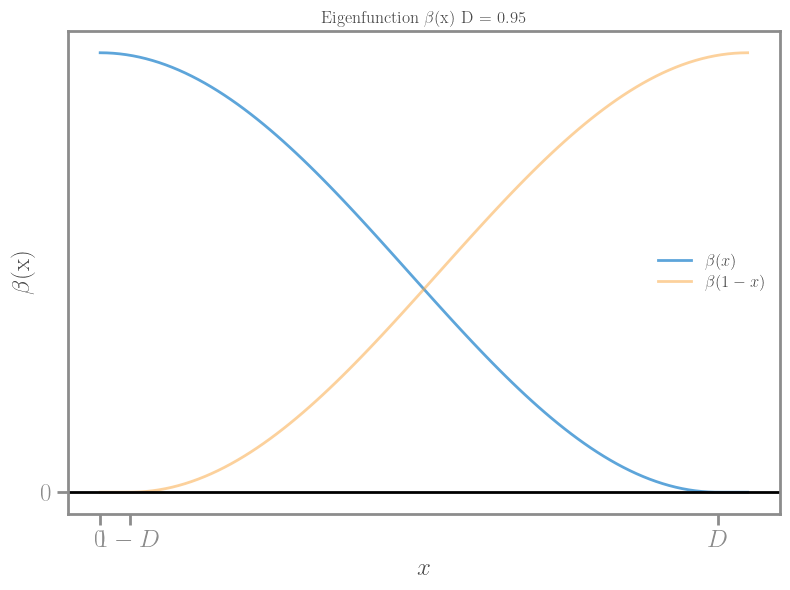

In [ ]:
parameters = book_of_the_numbers()
_eigenspace = solve_eigenspace_cone(parameters)

β, D = _eigenspace["β"], _eigenspace["D"]

# β_normalised = β.subs(normalisation[0])

β_func = sp.lambdify(x, β, 'numpy')

x_values = np.linspace(0, 1, 100)

fig, axis = plt.subplots(1, 1, figsize=(8, 6))

axis.plot(x_values, [β_func(x) for x in x_values], label='$\\beta(x)$')
axis.plot(x_values, [β_func(1-x) for x in x_values], label='$\\beta(1-x)$', alpha = .5)
axis.set_title(f'Eigenfunction $\\beta$(x) D = {np.around(float(sp.N(D)), 2)}')
axis.set_xlabel('$x$')
axis.axhline(0, c='k')
axis.set_ylabel('$\\beta$(x)')
axis.set_xticks([0, float(sp.N(D)), float(1-sp.N(D))], [0, "$D$", "$1-D$"])
axis.set_yticks([0], [0])

axis.legend()
fig.tight_layout()

In [ ]:
eigenspace = solve_eigenspace_cone(parameters)
v, β = eigenspace["v"], eigenspace["β"]
D = eigenspace["D"]

x_values = np.linspace(0, 1, 100)
v_function = sp.lambdify('x', v)
β_function = sp.lambdify('x', β)

v_values = [v_function(x) for x in x_values]
β_values = [β_function(x) for x in x_values]

case 2
sqrt(0.0341556015634623*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.0341556015634623*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.136622406253849*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.0341556015634623*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.0683112031269245*pi**0.666666666666667)*sqrt(C**2)
depends_on_C


### Vs the Crunch

In [ ]:
!ls '../../test/output/rayleigh-benchmark/MPI-1/'

ls: ../../test/output/rayleigh-benchmark/MPI-1/: No such file or directory


In [ ]:
experiment = '../../test/output/rayleigh-benchmark/MPI-1/e9276db499c49b725dbe8cb8ac8c9521'
params, data, signature = pp.load_data(experiment)


File 'time_data.json' not found. Handle this case accordingly.
no sig file found


In [ ]:
a = params['model']['a']
b = params['model']['b']
c = params['model']['c']

parameters = {"a": a, "b": b, "c": c}

parameters

{'a': 1, 'b': 1, 'c': 4}

case 2
[{A, x}, {A, x}]
sqrt(A**2/2 + 8*A**2/pi**2) True False
depends_on_A
case 2
sqrt(0.198425131496025*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.198425131496025*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.7937005259841*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.198425131496025*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.39685026299205*pi**0.666666666666667)*sqrt(C**2)
depends_on_C


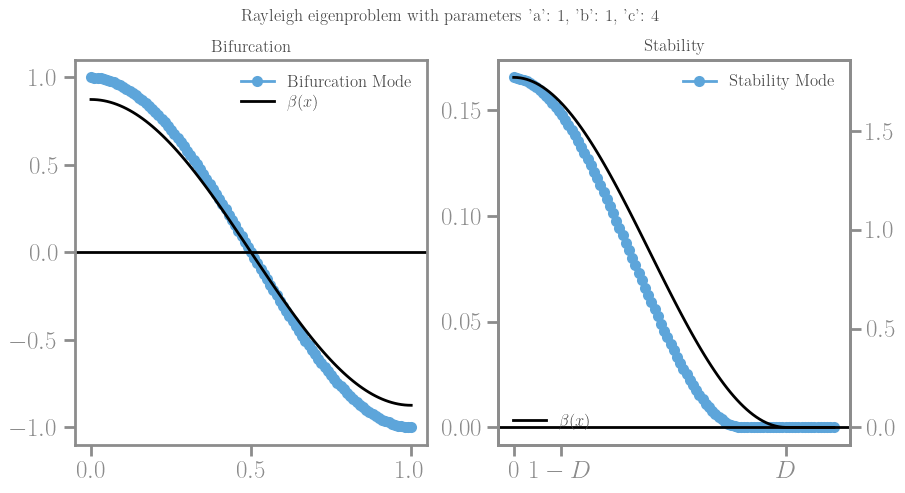

In [ ]:
modes_data = np.load(os.path.join(experiment, 'mode_shapes_data.npz'), allow_pickle=True)
mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=10)
_fig, _axes = pp.plot_fields_for_time_step(mode)
_fig.suptitle(f"Rayleigh eigenproblem with parameters {parameters}")
eigenspace_v = solve_eigenspace_vector(parameters, idx=1)

v, β = eigenspace_v["v"], eigenspace_v["β"]

x_values = np.linspace(0, 1, 100)
v_function = sp.lambdify('x', v)
β_function = sp.lambdify('x', β)
v_values = [v_function(x) for x in x_values]
β_values = [β_function(x) for x in x_values]

_axes[0].plot(x_values, β_values, label=r'$\beta(x)$', c='k')

eigenspace_k = solve_eigenspace_cone(parameters, idx=0)

v, β = eigenspace_k["v"], eigenspace_k["β"]
D = eigenspace_k["D"]
x_values = np.linspace(0, 1, 100)
v_function = sp.lambdify('x', v)
β_function = sp.lambdify('x', β)
v_values = [v_function(x) for x in x_values]
β_values = [β_function(x) for x in x_values]

__axes = _axes[1].twinx()
__axes.plot(x_values, β_values, label=r'$\beta(x)$', c='k')
__axes.set_xticks([0, float(sp.N(D)), float(1-sp.N(D))], [0, "$D$", "$1-D$"])

[_ax.legend() for _ax in _axes]
__axes.legend(loc='lower left')


In [ ]:

experiment = '../../test/output/rayleigh-benchmark/MPI-1/35dc528686badfde6e535184026e2c38'
params, data, signature = pp.load_data(experiment)
a = params['model']['a']
b = params['model']['b']
c = params['model']['c']

parameters = {"a": a, "b": b, "c": c}



File 'time_data.json' not found. Handle this case accordingly.


case 2
[{A, x}, {A, x}]
sqrt(A**2/2 + 32*A**2/pi**2) True False
depends_on_A
case 2
sqrt(0.125*sin(1.0*pi**1.0)*cos(1.0*pi**1.0)/pi**0.333333333333333 + 0.125*pi**0.666666666666667*sin(1.0*pi**1.0)**2 + 0.5*sin(1.0*pi**1.0)/pi**0.333333333333333 + 0.125*pi**0.666666666666667*cos(1.0*pi**1.0)**2 + 0.25*pi**0.666666666666667)*sqrt(C**2)
depends_on_C


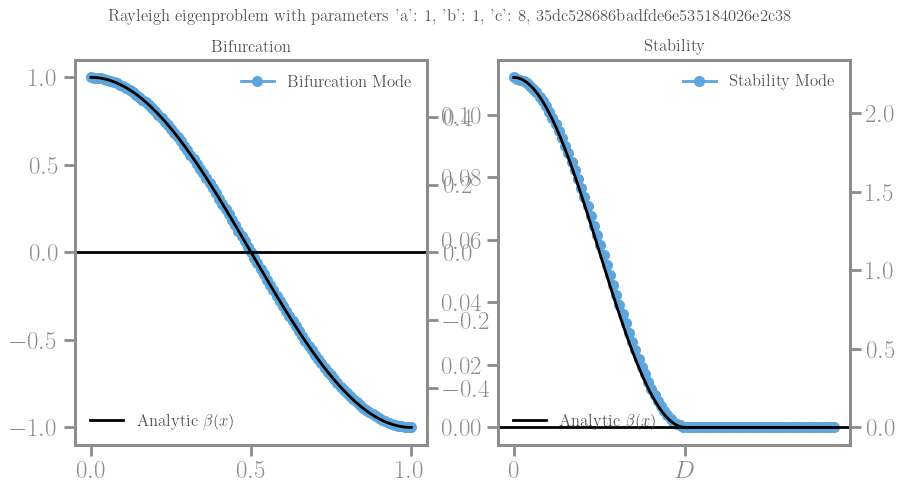

In [ ]:
modes_data = np.load(os.path.join(experiment, 'mode_shapes_data.npz'), allow_pickle=True)
mode = pp.read_mode_data_from_npz(modes_data, time_step=0, num_modes=1, num_points=10)
_fig, _axes = pp.plot_fields_for_time_step(mode)
_fig.suptitle(f"Rayleigh eigenproblem with parameters {parameters}, {signature}")
eigenspace_v = solve_eigenspace_vector(parameters, idx=1)

v, β = eigenspace_v["v"], eigenspace_v["β"]
x_values = np.linspace(0, 1, 100)
v_function = sp.lambdify('x', v)
β_function = sp.lambdify('x', β)
v_values = [v_function(x) for x in x_values]
β_values = [β_function(x) for x in x_values]

__ax1 = _axes[0].twinx()
__ax1.plot(x_values, β_values, label=r'Analytic $\beta(x)$', c='k')

eigenspace_k = solve_eigenspace_cone(parameters, idx=0)

v, β = eigenspace_k["v"], eigenspace_k["β"]
D = eigenspace_k["D"]
x_values = np.linspace(0, 1, 100)
v_function = sp.lambdify('x', v)
β_function = sp.lambdify('x', β)
v_values = [v_function(x) for x in x_values]
β_values = [β_function(x) for x in x_values]

__ax2 = _axes[1].twinx()
__ax2.plot(x_values, β_values, label=r'Analytic $\beta(x)$', c='k')
__ax2.set_xticks([0, float(sp.N(D))], [0, "$D$"])

[_ax.legend() for _ax in _axes]
[ax.legend(loc='lower left') for ax in (__ax1, __ax2)]

_fig.savefig(f"../../test/output/rayleigh-benchmark/verification-{signature}.pdf", bbox_inches='tight')
_fig.savefig(f"../../test/output/rayleigh-benchmark/verification-{signature}.png", bbox_inches='tight')

## Sandbox

import

In [ ]:
import pandas as pd
import os


In [ ]:
!ls ../../test/output/one-dimensional-bar/MPI-1/10/de9ac8eaeda8acc5076c911fe1b284ad

history_data.json               simulation_results.xdmf
mode_shapes_data.npz            stability_data.json
parameters.yaml                 time_data.json
perturbation-profile-3.png      traction-bar.h5
perturbation-profile-4.png      traction-bar.xdmf
perturbation-profile-cone-3.png traction-bar_energies.pdf
perturbation-profile-cone-4.png traction-bar_it_load.pdf
signature.md5                   traction-bar_stress-load.pdf
simulation_results.h5


In [ ]:
experiment = '../../test/output/one-dimensional-bar/MPI-1/10/de9ac8eaeda8acc5076c911fe1b284ad'

# df = pd.read_json(os.path.join(experiment, 'time_data.json'))
df = pd.read_json(os.path.join(experiment, 'stability_data.json'))


In [ ]:
params, data, signature = pp.load_data(experiment)

In [ ]:
params["stability"]["cone"]["cone_rtol"]

1e-06

In [ ]:
df.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414],
      dtype='int64', length=2415)

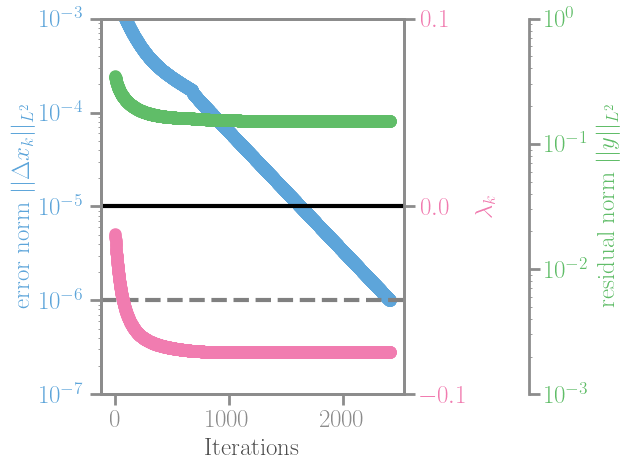

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# df = pd.read_json('your_file.json')  # Load your DataFrame

# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot 'error_x_L2' on the first y-axis
color = 'C0'
ax1.set_xlabel('Iterations')
ax1.set_ylabel(r'error norm $||\Delta x_k||_{L^2}$', color=color)
ax1.semilogy()
ax1.set_ylim(1e-7, 1e-3)
ax1.axhline(params["stability"]["cone"]["cone_rtol"], c='gray', linewidth=3, ls='--')
ax1.scatter(df.index, df['error_x_L2'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()
color = 'C3'
ax2.set_ylabel(r'$\lambda_k$', color=color)
ax2.set_ylim(-.1, .1)
ax2.axhline(0., c='k', linewidth=3)
ax2.set_yticks([-.1, 0, .1])
ax2.scatter(df.index, df['lambda_k'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add another twin axis for 'y_norm_L2'
ax3 = ax1.twinx()
color = 'C2'
ax3.spines['right'].set_position(('outward', 90))  # Offset the last axis
ax3.semilogy()
ax3.set_ylim(1e-3, 1e0)
ax3.set_ylabel(r'residual norm $||y||_{L^2}$', color=color)
ax3.scatter(df.index, df['y_norm_L2'], color=color)
ax3.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

# Show the plot
fig.savefig('test_1d_stability-spa.pdf', bbox_inches='tight')
fig.savefig('test_1d_stability-spa.png')
# plt.show()

## Umut benchmark AT2

In [ ]:
!ls ../../playground/benchmark-umut-at2/output/thinfilm-1d/MPI-1

+4bbca845ae2a0bf32f812c1a4fea5fc1 7f4361
136dbb                            7f4361886184f3c6791fe16bf4f4b3f2
4bbca845ae2a0bf32f812c1a4fea5fc1  973ea06bbe6ca0c7ef182834b9fac958


0

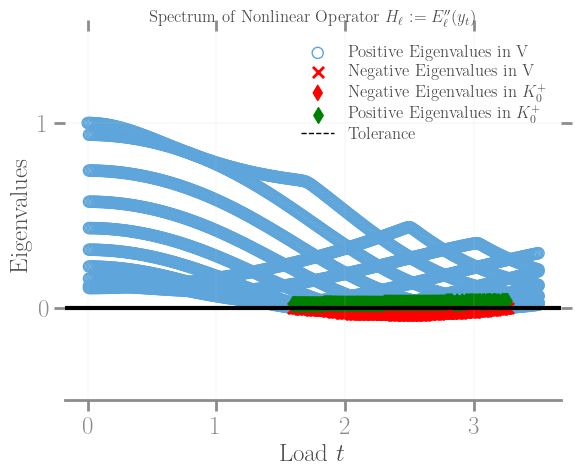

In [64]:
experiment = '../../playground/benchmark-umut-at2/output/thinfilm-1d/MPI-1/7f4361'
experiment = '../../playground/benchmark-umut-at2/output/thinfilm-1d/MPI-1/136dbb'
params, data, signature = pp.load_data(experiment)
ax = pp.plot_operator_spectrum(data, params)
# plt.axvline(fields_data["time_steps"][16], c='k', ls='--', lw=.5)

visuals.setspines0()


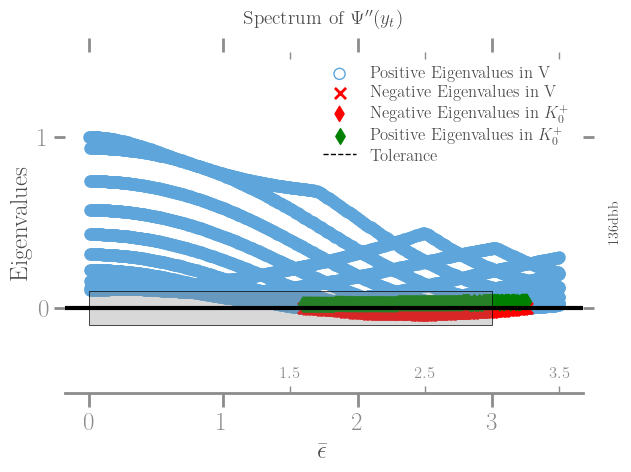

In [69]:
import matplotlib.patches as patches

ax = pp.plot_operator_spectrum(data, params)
ax.set_title(f"Spectrum of $\Psi''(y_t)$", fontsize=14, pad=20)
rect = patches.Rectangle((0, -.1), 3, 0.2, linewidth=1,
    edgecolor='black',
    lw=.5,
    facecolor=(0.5, 0.5, 0.5, 0.3))
ax.add_patch(rect)
ax.text(1.05, 0.5, signature[0:6], rotation=90, verticalalignment='center',
             transform=ax.transAxes, fontdict={'family': 'monospace'}, 
             fontname='monospace')

ax.get_figure().tight_layout()
visuals.setspines0()
# plt.axvline(fields_data["time_steps"][16], c='k', ls='--', lw=.5)
ax.set_xlabel('$\\bar \\epsilon$')

# ax.set_xticks([fields_data["time_steps"][16]], ['$\\bar \\epsilon_b$'])

# ax.set_xticks([point[0] for point in points_list],
#                [*[f'$\\bar \\epsilon_{i}$' for i in range(1, len(points_list)+1)]])
ax.tick_params(axis='x', which='major', direction='out', length=10, width=2)

ax.set_xticks(np.arange(1.5, 4.5), np.arange(1.5,  4.5),  minor=True)
ax.tick_params(axis='x', which='minor', direction='in', length=5, width=1, pad=-20, labelsize=12)



_lines = ax.collections[0]
_lines.set_facecolor('C0')
ax.grid(False)

plt.savefig(f"../../playground/benchmark-umut-at2/output/thinfilm-1d/spectra-{signature}.pdf",
            bbox_inches='tight')
# plt.savefig(f"../../playground/benchmark-umut-at2/output/thinfilm-1d/spectra-{signature}-empty.pdf",
#             bbox_inches='tight')

plt.savefig(f"/Users/kumiori3/Documents/WIP/Nature/paper_UMUT/images/spectra-{signature}.pdf",
            bbox_inches='tight')



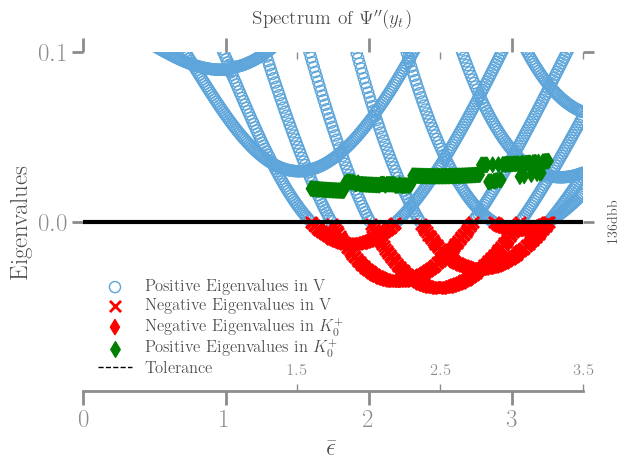

In [70]:
ax_zoom = pp.plot_operator_spectrum(data, params)
ax_zoom.set_xlim(0, 3)
ax_zoom.set_ylim(-.1, .1)
ax_zoom.set_yticks([0, .1])
ax_zoom.set_xticks(range(4))
ax_zoom.set_title(f"Spectrum of $\Psi''(y_t)$", fontsize=14, pad=20)

ax_zoom.set_xlabel('$\\bar \\epsilon$')
# ax_zoom.text(1.05, 0.5, signature, rotation=90, verticalalignment='center',
#              transform=ax.transAxes, fontdict={'family': 'monospace'}, fontname='monospace')

# ax_zoom.legend()
ax_zoom.text(1.05, 0.5, signature[0:6], rotation=90,
             verticalalignment='center',
             transform=ax_zoom.transAxes, fontdict={'family': 'monospace'}, 
             fontname='monospace')

# ax_zoom.get_figure().tight_layout()
visuals.setspines0()
# plt.axvline(fields_data["time_steps"][16], c='k', ls='--', lw=.5)
ax_zoom.set_xlabel('$\\bar \\epsilon$')
ax_zoom.grid(False)

# ax_zoom.set_xticks([fields_data["time_steps"][16]], ['$\\bar \\epsilon_b$'])

ax_zoom.tick_params(axis='x', which='major', direction='out', length=10, width=2)

ax_zoom.set_xticks(np.arange(1.5, 4.5), np.arange(1.5,  4.5),  minor=True)
ax_zoom.tick_params(axis='x', which='minor', direction='in', length=5, width=1, pad=-20, labelsize=12)


plt.tight_layout()
plt.savefig(f"../../playground/benchmark-umut-at2/output/thinfilm-1d/spectra-zoom-{signature}.pdf",
            bbox_inches='tight')

plt.savefig(f"/Users/kumiori3/Documents/WIP/Nature/paper_UMUT/images/spectra-zoom-{signature}.pdf",
            bbox_inches='tight')



In [28]:
params["stability"]["cone"]["cone_rtol"]

1e-06

### Fields

In [14]:
fields_data = np.load(os.path.join(experiment, 'fields_data.npz'), allow_pickle=True)

pp.read_mode_data_from_npz(fields_data, time_step=1.6551724137931034)

No data available for mode 1 at timestep 1.6551724137931034.


{'mesh': array([0.001  , 0.01098, 0.02096, 0.03094, 0.04092, 0.0509 , 0.06088,
        0.07086, 0.08084, 0.09082, 0.1008 , 0.11078, 0.12076, 0.13074,
        0.14072, 0.1507 , 0.16068, 0.17066, 0.18064, 0.19062, 0.2006 ,
        0.21058, 0.22056, 0.23054, 0.24052, 0.2505 , 0.26048, 0.27046,
        0.28044, 0.29042, 0.3004 , 0.31038, 0.32036, 0.33034, 0.34032,
        0.3503 , 0.36028, 0.37026, 0.38024, 0.39022, 0.4002 , 0.41018,
        0.42016, 0.43014, 0.44012, 0.4501 , 0.46008, 0.47006, 0.48004,
        0.49002, 0.5    , 0.50998, 0.51996, 0.52994, 0.53992, 0.5499 ,
        0.55988, 0.56986, 0.57984, 0.58982, 0.5998 , 0.60978, 0.61976,
        0.62974, 0.63972, 0.6497 , 0.65968, 0.66966, 0.67964, 0.68962,
        0.6996 , 0.70958, 0.71956, 0.72954, 0.73952, 0.7495 , 0.75948,
        0.76946, 0.77944, 0.78942, 0.7994 , 0.80938, 0.81936, 0.82934,
        0.83932, 0.8493 , 0.85928, 0.86926, 0.87924, 0.88922, 0.8992 ,
        0.90918, 0.91916, 0.92914, 0.93912, 0.9491 , 0.95908, 0.96906

In [13]:
fields_data["time_steps"][16]

1.6551724137931034

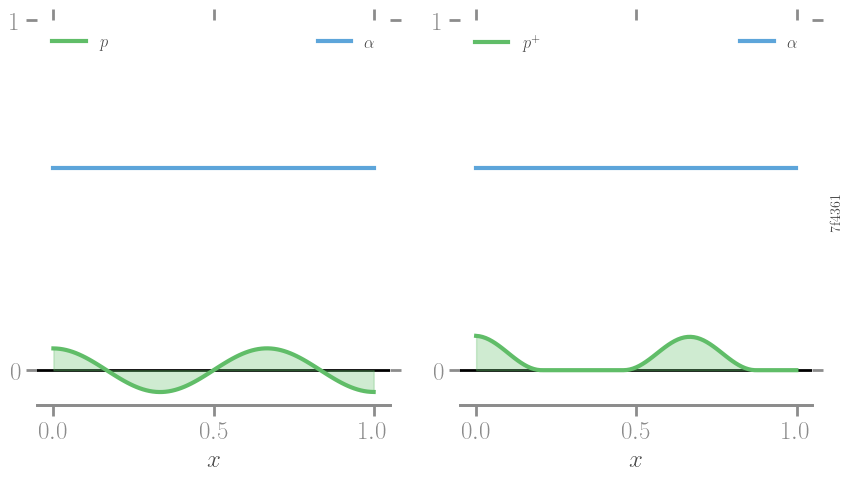

In [149]:

# def read_fields_data_from_npz(npz_file, time_step, num_points=-1, num_modes=1):
"""
Read mode data for a given timestep and x_values from an npz file.

Parameters:
- npz_file (numpy.lib.npyio.NpzFile): The npz file containing mode shapes data.
- time_step (int): The timestep to read.
- num_modes (int): The number of modes.
- num_points (int): The number of domain nodes.

Returns:
- mode_data (dict): A dictionary containing mode-specific fields for the given timestep.
"""

npz_file = fields_data
time_index = 16

if 'time_steps' not in npz_file:
    print(f"No timestep data available.")
    # return None

# index = np.where(npz_file['time_steps'] == time_step)[0][0]
index = time_index
field_names = fields_data['point_values'].item().keys()
fields = fields_data['point_values'].item()

data = {label: 0 for label in field_names}

for label in field_names:
    # fields_data['point_values'].item()[label]
    data[label] = fields_data['point_values'].item()[label][index]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))


for ax in axes:
    ax.plot(
        fields_data['mesh'],
        data['equilibrium_α'],
        label='$\\alpha$', lw=3)

    ax.set_xlabel('$x$')
    ax.axhline(0, c='k', ls='-')
    ax.legend()
    ax.set_ylim(-.1, 1)
    ax.set_yticks([0, 1])

_ax_b = axes[0].twiny()

_ax_b.plot(
    fields_data['mesh'],
    .05*data['bifurcation_β'],
    label='$p$', c='C2', lw=3)
_ax_b.fill_between(
    fields_data['mesh'],
    .05*data['bifurcation_β'], color='C2', alpha=.3)

_ax_s = axes[1].twiny()
_ax_s.plot(
    fields_data['mesh'],
    .05*data['stability_β'],
    label='$p^+$', c='C2', lw=3)
_ax_s.fill_between(
    fields_data['mesh'],
    .05*data['stability_β'], color='C2', alpha=.3)

_ax_s.text(1.05, 0.5, signature[0:6], rotation=90, verticalalignment='center',
             transform=ax.transAxes, fontdict={'family': 'monospace'}, 
             fontname='monospace')

for ax in [_ax_b, _ax_s]:
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.legend(loc='upper left')

visuals.setspines0()
plt.savefig(f"../../playground/benchmark-umut-at2/output/thinfilm-1d/profiles-bif-stab-{signature}.pdf",
            bbox_inches='tight')
plt.savefig(f"/Users/kumiori3/Documents/WIP/Nature/paper_UMUT/images/profiles-bif-stab-{signature}.pdf",
            bbox_inches='tight')



In [28]:
field_names = fields_data['point_values'].item().keys()
field_names

dict_keys(['equilibrium_u', 'equilibrium_α', 'bifurcation_v', 'bifurcation_β', 'stability_v', 'stability_β'])

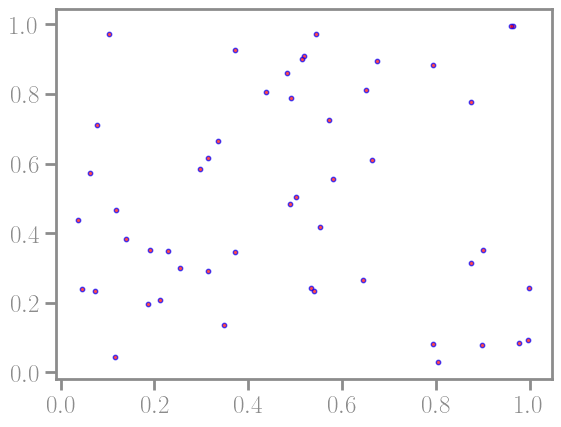

In [131]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
x = np.random.rand(50)
y = np.random.rand(50)

# Create scatter plot
fig, ax = plt.subplots()
sc = ax.scatter(x, y)

# Change the color and marker
for scatter in ax.collections:
    scatter.set_facecolor('red')    # Change the face color of the markers
    scatter.set_edgecolor('blue')   # Change the edge color of the markers
    scatter.set_sizes([10])        # Change the size of the markers
    scatter.set_alpha(0.7)          # Change the transparency of the markers
    # Note: PathCollection does not have a method to change the marker directly,
    # so you need to recreate the scatter plot if you need to change the marker style.

plt.show()